In [1]:
from start1 import *

In [2]:
# 数据集获取
def get_cifar10(data_path, batch_size):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

    return train_loader,test_loader

In [ ]:
root_dir = r'../data'
batch_size=512
lr= 1e-1 * (batch_size/256) # 当batch_size过大时，通过增大学习率降低梯度中的噪声
weight_decay = 0.
warmup = True
num_epochs = 20
warmup_epochs = 5
num_classes = 10
data_type = 0  # 数据是否具有时间维度，0表示没有，1表示有
T = 4 # 静态数据需要的时间步
T_data = 0 # 代表数据本身已经有时间维度或者网络对数据添加时间维度了，不需要自己再加了,一般会在网络中直接加入时间步，所以基本上这个值都是0

train_loader,test_loader = get_cifar10(root_dir, batch_size = batch_size)
# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = 3,num_classes = num_classes, connect_f = 'ADD',T = T).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)
pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)
loss_function = F.mse_loss
loss_function = nn.CrossEntropyLoss(label_smoothing = 0.1)
# scaler = None
scaler = amp.GradScaler()

In [ ]:
train_accs,train_losss,test_accs,test_losss = trains(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_cifar10.pt", lr_scheduler = lr_scheduler)

##### 1.标签平滑

In [26]:
# 最终得到的就是标签平滑后的张量，使用独热编码
import torch
import torch.nn as nn
class LSR(nn.Module):
    def __init__(self, e=0.1, reduction='mean'):
            super().__init__()
            self.log_softmax = nn.LogSoftmax(dim=1)
            self.e = e
            self.reduction = reduction
    def _one_hot(self, labels, classes, value=1):
        """
            Convert labels to one hot vectors
            思路就是：首先创建一个二维张量，接着按照标签的个数创建一个值为1的列，使二维张量对应的标签位置加上这个值。
        Args:
            labels: torch tensor in format [label1, label2, label3, ...]
            classes: int, number of classes
            value: label value in one hot vector, default to 1
        Returns:
            return one hot format labels in shape [batchsize, classes]
        """
        one_hot = torch.zeros(labels.size(0), classes)
#         labels and value_added  size must match
        labels = labels.view(labels.size(0), -1)
        value_added = torch.Tensor(labels.size(0), 1).fill_(value)
        value_added = value_added.to(labels.device)
        one_hot = one_hot.to(labels.device)
        # (dim, index, src)
        one_hot.scatter_add_(1, labels, value_added)
        return one_hot

    def _smooth_label(self, target, length, smooth_factor):
        """convert targets to one-hot format, and smooth
        them.
        Args:
            target: target in form with [label1, label2, label_batchsize]
            length: length of one-hot format(number of classes)
            smooth_factor: smooth factor for label smooth
        Returns:
            smoothed labels in one hot format
        """
        one_hot = self._one_hot(target, length, value=1- smooth_factor)
        one_hot += smooth_factor / length
        return one_hot.to(target.device)

In [65]:
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.9, 0.2, 0.2, 1],
                             [1, 0.2, 0.7, 0.9, 1]])
target = torch.LongTensor([2,1,0])
classes = 5 # 类别数量是target最大值 + 1
smooth_factor = 0.3
target = LSR()._smooth_label(target, classes,smooth_factor)
loss_func = F.mse_loss
loss = loss_func(predict,target)
loss

tensor(0.2036)

In [21]:
# 使用交叉熵损失函数时，如何使用标签平滑
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [43]:
x = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                     [0, 0.9, 0.2, 0.2, 1],
                     [1, 0.2, 0.7, 0.9, 1]])

target = torch.LongTensor([2, 1, 0])
logprobs = torch.nn.functional.log_softmax(x, dim=-1)
logprobs
nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
nll_loss
smooth_loss = -logprobs.mean(dim=-1)
smooth_loss
loss = 0.9 * nll_loss + 0.1 * smooth_loss
loss

tensor([[-1.8469, -1.6469, -1.1469, -1.7469, -1.8469],
        [-2.1542, -1.2542, -1.9542, -1.9542, -1.1542],
        [-1.4098, -2.2098, -1.7098, -1.5098, -1.4098]])

tensor([[1.1469],
        [1.2542],
        [1.4098]])

tensor([1.6469, 1.6942, 1.6498])

tensor([[1.1969, 1.2017, 1.1972],
        [1.2934, 1.2982, 1.2937],
        [1.4335, 1.4382, 1.4338]])

In [56]:
# NVIDIA 
crit = LabelSmoothing(smoothing=0.3)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.9, 0.2, 0.2, 1],
                             [1, 0.2, 0.7, 0.9, 1]])
v = crit(predict,torch.LongTensor([2, 1, 0]))
print(v)

# tensor(1.3883)

tensor(1.3883)


In [66]:
# 使用CrossEntropyLoss 可以直接设置标签
loss_func = nn.CrossEntropyLoss(label_smoothing = 0.3)
v = torch.LongTensor([2, 1, 0])
loss_func(predict ,v)
# tensor(1.3883)

tensor(1.3883)

##### Random image cropping and patching  图像的随机裁剪和拼接
挑选k张图像，在每一张图片上裁剪对应位置的图像，之后把裁剪完的图像进行拼接，保证拼接完图像的长和宽与原来一样即可

In [69]:
root_dir = r'../data'
batch_size = 512
train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)

In [97]:
beta = 0.3# hyperparameter
for(images, targets) in train_loader:
    # get the image size,长和宽
    I_x, I_y = images.size()[2:]
    # draw a boundry position (w, h)
    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]
    # select and crop four images
    cropped_images = {}
    c_ = {}
    W_ = {}
    index = torch.randperm(images.size(0))
    for k in range(4):
        # 每次随机挑选四张图片进行训练
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = images[index[k]][:, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        print(cropped_images[k].shape)
        c_[k] = targets[index[k]].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)
    # patch cropped images
    patched_images = torch.cat((torch.cat((cropped_images[0], cropped_images[1]), 1),
                torch.cat((cropped_images[2], cropped_images[3]), 1)), 2)
    print(patched_images.shape) 
    break
#     #patched_images = patched_images.cuda()
#     # get output
#     output = model(patched_images)
#     # calculate loss and accuracy
#     loss = sum([W_[k] * criterion(output, c_[k]) for k in range(4)])
#     acc = sum([W_[k] * accuracy(output, c_[k])[0] for k in range(4)])

torch.Size([3, 13, 32])
torch.Size([3, 19, 32])
torch.Size([3, 13, 0])
torch.Size([3, 19, 0])
torch.Size([3, 32, 32])


<Figure size 100x100 with 0 Axes>

(-0.5, 31.5, 31.5, -0.5)

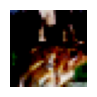

In [113]:
image = patched_images.permute(1, 2, 0)
# 绘制图像
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

<Figure size 100x100 with 0 Axes>

(-0.5, 31.5, 31.5, -0.5)

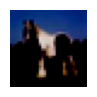

In [110]:
image = images[index[0]].permute(1, 2, 0)
# 绘制图像
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

<Figure size 100x100 with 0 Axes>

(-0.5, 31.5, 31.5, -0.5)

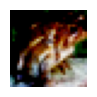

In [108]:
image = images[index[1]].permute(1, 2, 0)
# 绘制图像
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

<Figure size 100x100 with 0 Axes>

(-0.5, 31.5, 31.5, -0.5)

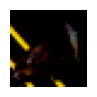

In [111]:
image = images[index[2]].permute(1, 2, 0)
# 绘制图像
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

<Figure size 100x100 with 0 Axes>

(-0.5, 31.5, 31.5, -0.5)

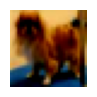

In [112]:
image = images[index[3]].permute(1, 2, 0)
# 绘制图像
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

##### Cutout，训练时把图像的一部分减掉

In [3]:
root_dir = r'../data'
batch_size = 512
train_loader,test_loader = get_cifar10(root_dir, batch_size = 512)

In [34]:
import torch
import numpy as np

class Cutout(object):
    """
    Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length
    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)  # 在 0到h之间产生一个随机整数
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h) # 确保y1在0到y之间，下同
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.  # 将这部分图像的像素置为0
            mask = torch.from_numpy(mask) # NumPy 数组转换为 PyTorch 张量 (tensor)
            mask = mask.expand_as(img) # mask 张量的形状扩展为与 img 张量相同的形状
            img = img * mask # 执行逐元素乘法操作，即将两个张量 img 和 mask 中对应位置的元素相乘
        return img

In [19]:
# for image,y in train_loader:
#     print(image.shape)
#     print(y.shape)
#     break
# length = 10
# h = image[0].size(1)
# w = image[0].size(2)
# mask = np.ones((h, w), np.float32)
# print(mask.shape)
# y = np.random.randint(h)  # 在 0到h之间产生一个随机整数
# x = np.random.randint(w)
# y1 = np.clip(y - length // 2, 0, h) # 确保y1在0到y之间，下同
# y2 = np.clip(y + length // 2, 0, h)
# x1 = np.clip(x - length // 2, 0, w)
# x2 = np.clip(x + length // 2, 0, w)
# mask[y1: y2, x1: x2] = 0.  # 将这部分图像的像素置为0
# mask = torch.from_numpy(mask) # NumPy 数组转换为 PyTorch 张量 (tensor)
# mask = mask.expand_as(image[0]) # mask 张量的形状扩展为与 img 张量相同的形状
# print(mask.shape) 
# img = img * mask  # 执行逐元素乘法操作，即将两个张量 img 和 mask 中对应位置的元素相乘

torch.Size([512, 3, 32, 32])
torch.Size([512])


##### Random erasing  
cutout是把图片中随机抽中的矩形区域的像素值置为0，相当于裁剪掉，random erasing是用随机数或者数据集中像素的平均值替换原来的像素值。而且，cutout每次裁剪掉的区域大小是固定的，Random erasing替换掉的区域大小是随机的。

In [46]:
class RandomErasing(object):
    '''
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio 最小高宽比，一般指的是宽高比
    mean: erasing value
    '''
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
    def __call__(self, img):
        if random.uniform(0, 1) > self.probability:
            return img
        for attempt in range(100):
            # 总区域大小
            area = img.size()[1] * img.size()[2]
            # 目标区域大小  比例*总区域大小
            target_area = random.uniform(self.sl, self.sh) * area
            # 让高宽比在 这两个值之间
            aspect_ratio = random.uniform(self.r1, 1/self.r1)
            # 擦除区域的高
            h = int(round(math.sqrt(target_area * aspect_ratio)))
            # 擦除区域的宽
            w = int(round(math.sqrt(target_area / aspect_ratio)))
            # 挑选擦除区域 高和宽的 起始点
            if w < img.size()[2] and h < img.size()[1]:
                # 高的起始点
                x1 = random.randint(0, img.size()[1] - h)
                # 宽的起始点
                y1 = random.randint(0, img.size()[2] - w)
                # 如果图像是三通道
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                # 图像是单通道
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                # 返回擦除的图像
                return img
        # 尝试100次都没有找到需要擦除的图像后就返回原图像
        return img

##### mixup

In [ ]:
for(images, labels) in train_loader:
    l = np.random.beta(mixup_alpha, mixup_alpha)
    index = torch.randperm(images.size(0))
    images_a, images_b = images, images[index]
    labels_a, labels_b = labels, labels[index]
    mixed_images = l * images_a + (1- l) * images_b
    outputs = model(mixed_images)
    loss = l * criterion(outputs, labels_a) + (1- l) * criterion(outputs, labels_b)
    acc = l * accuracy(outputs, labels_a)[0] + (1- l) * accuracy(outputs, labels_b)[0]

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 汇总 

In [1]:
from start1 import *

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

#### 1. 数据集读取  
基本不使用transform

DVS128Gesture

In [56]:
# 数据集获取   DVS128Gesture 11种类别，分别包含：Swipe left  Swipe right  Swipe up   Swipe down   Circle left   Circle right   Tap
# Double tap    Forward     Backward    Stop
def get_dvs128Gesture(data_path = r'../data/DVS128Gesture', batch_size = 16, T = 20):
    train_set = DVS128Gesture(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
    test_set = DVS128Gesture(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [3]:
train_loader,test_loader = get_dvs128Gesture()
len(train_loader)
len(test_loader)

The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.
The directory [../data/DVS128Gesture\frames_number_20_split_by_number] already exists.


73

18

CIFAR10DVS

In [19]:
# 数据集获取  CIFAR10DVS  10个类别
def get_cifar10dvs(train_path = r'../data/CIFAR10DVS/split/t20/train0.8.pth', 
                   test_path = r'../data/CIFAR10DVS/split/t20/test0.2.pth',
                   batch_size = 64, T = 20):
    train_set = torch.load(train_path, weights_only=False)
    test_set = torch.load(test_path, weights_only=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [20]:
train_loader,test_loader = get_cifar10dvs()
len(train_loader)
len(test_loader)

125

31

In [28]:
# datas = iter(train_loader)
# a,b = next(datas)
# a.shape
# a

torch.Size([64, 20, 2, 128, 128])

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 0., 0.],
           [0., 1., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[1., 2., 1.,  ..., 1., 2., 1.],
           [2., 1., 2.,  ..., 2., 1., 1.],
           [1., 1., 1.,  ..., 1., 2., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 1., 0.],
           [1., 1., 0.,  ..., 0., 0., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 1., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 0., 1., 0.],
           [1., 2., 0.,  ..., 0., 0., 1.],
           ...,
           [0., 0., 0.,  

NMNIST

In [50]:
# 数据集获取   NMNIST  10个类别
def get_nmnist(data_path = r'../data/NMNIST', batch_size = 512, T = 20):
    train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
    test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [51]:
train_loader,test_loader = get_nmnist()
len(train_loader)
len(test_loader)

The directory [../data/NMNIST\frames_number_20_split_by_number] already exists.
The directory [../data/NMNIST\frames_number_20_split_by_number] already exists.


117

19

NCaltech101

In [52]:
# 数据集获取  NCaltech101    包含 101 个类别。这些类别主要是不同的物体，如动物、植物、物品等。
def get_NCaltech101(train_path = r'../data/NCaltech101/split/t20/train0.8.pth', 
                   test_path = r'../data/NCaltech101/split/t20/test0.2.pth',
                   batch_size = 64, T = 20):
    train_set = torch.load(train_path, weights_only=False)
    test_set = torch.load(test_path, weights_only=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [53]:
train_loader,test_loader = get_NCaltech101()
len(train_loader)
len(test_loader)

109

26

MNIST

In [54]:
# 数据集获取  MNIST   10个类别
def get_mnist(data_path = r'../data', batch_size = 512):
    # Define a transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 将图像转为灰度
        transforms.ToTensor(),  # 将图像转为张量
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
    mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)
    
    return train_loader,test_loader

In [55]:
train_loader,test_loader = get_mnist()
len(train_loader)
len(test_loader)

117

19

Cifar10

In [57]:
# 数据集获取  Cifar10   10个类别
def get_cifar10(data_path = r'../data', batch_size = 512):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
    testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True,
                                            pin_memory=True, persistent_workers = True, num_workers = 1)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,drop_last=True,
                                           pin_memory=True, persistent_workers = True, num_workers = 1)
    return train_loader,test_loader

In [58]:
train_loader,test_loader = get_cifar10()
len(train_loader)
len(test_loader)

97

19

cifar100

In [59]:
# 数据集获取  cifar100   100个类别
def get_cifar100(data_path = r'../data', batch_size = 512):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR100(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR100(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True,
                                            pin_memory=True, persistent_workers = True, num_workers = 1)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,drop_last=True,
                                           pin_memory=True, persistent_workers = True, num_workers = 1)

    return train_loader,test_loader

In [60]:
train_loader,test_loader = get_cifar100()
len(train_loader)
len(test_loader)

97

19

imagenet1k

In [45]:
# 数据集获取  imagenet_1k   1000个类别
def get_imagenet(data_path = r'../data/Imagenet2012/imagenet', batch_size = 32):
    
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,drop_last = True,
                                               pin_memory=True, persistent_workers = True, num_workers = 1)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=False,drop_last = True,
                                             pin_memory=True, persistent_workers = True, num_workers = 1)
    return train_loader,val_loader

In [61]:
# num_workers = 2 或 4 速度差不多，均为8.2s左右
start = time.time()
train_loader,test_loader = get_imagenet()
len(train_loader)
len(test_loader)
print(time.time() - start)

40036

1562

8.335187673568726


In [1]:
from start1 import *

In [2]:
# 数据集获取   DVS128Gesture 11种类别，分别包含：Swipe left  Swipe right  Swipe up   Swipe down   Circle left   Circle right   Tap
# Double tap    Forward     Backward    Stop
def get_dvs128Gesture(data_path = r'../data/DVS128Gesture', batch_size = 16, T = 20):
    train_set = DVS128Gesture(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
    test_set = DVS128Gesture(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

# 数据集获取  CIFAR10DVS  10个类别
def get_cifar10dvs(train_path = r'../data/CIFAR10DVS/split/t20/train0.8.pth', 
                   test_path = r'../data/CIFAR10DVS/split/t20/test0.2.pth',
                   batch_size = 64, T = 20):
    train_set = torch.load(train_path, weights_only=False)
    test_set = torch.load(test_path, weights_only=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

# 数据集获取   NMNIST  10个类别
def get_nmnist(data_path = r'../data/NMNIST', batch_size = 512, T = 20):
    train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
    test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

# 数据集获取  NCaltech101    包含 101 个类别。这些类别主要是不同的物体，如动物、植物、物品等。
def get_NCaltech101(train_path = r'../data/NCaltech101/split/t20/train0.8.pth', 
                   test_path = r'../data/NCaltech101/split/t20/test0.2.pth',
                   batch_size = 64, T = 20):
    train_set = torch.load(train_path, weights_only=False)
    test_set = torch.load(test_path, weights_only=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

# 数据集获取  MNIST   10个类别
def get_mnist(data_path = r'../data', batch_size = 512):
    # Define a transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 将图像转为灰度
        transforms.ToTensor(),  # 将图像转为张量
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
    mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)
    
    return train_loader,test_loader

# 数据集获取  Cifar10   10个类别
def get_cifar10(data_path = r'../data', batch_size = 512):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
    testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True,
                                            pin_memory=True, persistent_workers = True, num_workers = 1)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,drop_last=True,
                                           pin_memory=True, persistent_workers = True, num_workers = 1)
    return train_loader,test_loader

# 数据集获取  cifar100   100个类别
def get_cifar100(data_path = r'../data', batch_size = 512):
    # 定义数据变换
    transform = transforms.Compose(
        [transforms.ToTensor(),  # 将图片转换为Tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
    # 下载CIFAR10数据集
    # #训练集
    trainset=datasets.CIFAR100(root=data_path,train=True,download=False,transform=transform)
    # 测试集
    testset=datasets.CIFAR100(root=data_path,train=False,download=False,transform=transform)

    #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
    # 创建DataLoader对象
    train_loader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,drop_last=True,
                                            pin_memory=True, persistent_workers = True, num_workers = 1)
    test_loader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,drop_last=True,
                                           pin_memory=True, persistent_workers = True, num_workers = 1)

    return train_loader,test_loader

# 数据集获取  imagenet_1k   1000个类别
def get_imagenet(data_path = r'../data/Imagenet2012/imagenet', batch_size = 32):
    
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,drop_last = True,
                                               pin_memory=True, persistent_workers = True, num_workers = 1)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=False,drop_last = True,
                                             pin_memory=True, persistent_workers = True, num_workers = 1)
    return train_loader,val_loader

#### 2 数据集训练

cifar10DVS

In [65]:
root_dir = r'../data/CIFAR10DVS'
T = 20 # 对于非DVS执行的时间步，该数据集在划分的时候默认为5
batch_size=64
lr=1e-2
weight_decay = 1e-5
warmup = True
num_epochs = 5
warmup_epochs = 2
num_classes = 10
inp_channels = 2  # DVS系列的数据集貌似都是2
data_type = 1 # 0表示数据没有时间维度，1表示数据有时间维度
if_lrsche = 1  # 是否使用学习率调度策略
T_data = 0 # 该参数轻易不用，一般的，数据中没有时间步，网络中也会自动添加时间步

train_loader,test_loader = get_cifar10dvs()

# 设备选择使用GPU   数据的维度  B, T , 2, 128, 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = sew_resnet18(input_channels = inp_channels,num_classes = num_classes, connect_f = 'ADD',T = T, data_type = data_type).to(device)
# (block, layers, input_channels = 3, num_classes=1000, zero_init_residual=False,groups=1, 
#  width_per_group=64, replace_stride_with_dilation=None,norm_layer=None, T=4, connect_f=None, 
#  drops = [0,0,0,0], p = [0.5,0.5,0.5,0.5], data_type = 0, net_type = 0)

# # 使用Adam优化器
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# # 学习率优化
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

pg = get_params_groups(net, weight_decay=weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = optim.AdamW(pg, lr=lr, weight_decay=weight_decay)
lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), num_epochs,
                                   warmup=warmup, warmup_epochs=warmup_epochs)

# loss_function = nn.CrossEntropyLoss()
loss_function = F.mse_loss

# scaler = None
scaler = amp.GradScaler()

In [ ]:
train_accs,train_losss,test_accs,test_losss = trains(num_epochs, net, train_loader,
        test_loader, optimizer, device, loss_function, scaler = scaler, 
        encoder = encoding.PoissonEncoder(), T = T_data, num_classes = num_classes, 
        data_type = data_type, save_model = "./save_models/test_cifar10DVS.pt", lr_scheduler = lr_scheduler)

#### 3 重新更改训练函数

将所有超参数使用函数进行包装,依然是使用 CIFAR10DVS 进行训练  
注意只有CIFAR10DVS 和 NCaltech10 这两个数据集 需要手动划分 

In [ ]:
# from start2 import *

In [ ]:
# # NCaltech101数据集的手动划分
# data_path = r'../data/NCaltech101'
# T = 20
# num_classes = 101
# data = NCaltech101(root=data_path, data_type='frame', frames_number=T, split_by='number')

# train_set, test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split =True)
# torch.save(train_set, r'../data/NCaltech101/split/t20/train0.8.pth')
# torch.save(test_set, r'../data/NCaltech101/split/t20/test0.2.pth')
# train_data = torch.load(r'../data/NCaltech101/split/t20/train0.8.pth')
# test_set = torch.load(r'../data/NCaltech101/split/t20/test0.2.pth')
# print(train_data)

In [ ]:
# # CIFAR10DVS数据集的手动划分
# data_path = r'../data/CIFAR10DVS'
# T = 20
# num_classes = 10
# data = CIFAR10DVS(root = data_path, data_type='frame', frames_number=T, split_by='number')

# train_set, test_set = sptt(train_ratio = 0.8,origin_dataset = data,num_classes = num_classes,random_split = False)
# torch.save(train_set, r'../data/CIFAR10DVS/split/t20/train0.8.pth')
# torch.save(test_set, r'../data/CIFAR10DVS/split/t20/test0.2.pth')
# train_data = torch.load(r'../data/CIFAR10DVS/split/t20/train0.8.pth')
# test_data = torch.load(r'../data/CIFAR10DVS/split/t20/test0.2.pth')
# print(len(train_data), len(test_data))

各个数据集的获取方式，包括4个DVS数据集，4个静态图片数据集  
nmnist，NCaltech101，dvs128Gesture，cifar10dvs，mnist，cifar10，cifar100，imagenet

In [1]:
# from start2 import *

In [4]:
# # 数据集获取   NMNIST  10个类别
# def get_nmnist_2(batch_size = 16, num_workers = 4, T = 20,
#                data_path = r'E:\mycode\jupyter\0.SNN\data\NMNIST',
#               ):
#     train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
#     test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取  NCaltech101    包含 101 个类别。这些类别主要是不同的物体，如动物、植物、物品等。
# def get_NCaltech101_2(batch_size = 16, num_workers = 4, T = 20,
#                     train_path = r'E:\mycode\jupyter\0.SNN\data\NCaltech101\split\t20\train0.8.pth', 
#                     test_path = r'E:\mycode\jupyter\0.SNN\data\NCaltech101\split\t20\test0.2.pth',
#                        ):
#     train_set = torch.load(train_path, weights_only=False)
#     test_set = torch.load(test_path, weights_only=False)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取   DVS128Gesture 11种类别，分别包含：Swipe left  Swipe right  Swipe up   Swipe down   Circle left   Circle right   Tap
# # Double tap    Forward     Backward    Stop
# def get_dvs128Gesture_2(batch_size = 16,num_workers = 4,T = 20,
#                       data_path = r'E:\mycode\jupyter\0.SNN\data\DVS128Gesture',
#                      ):
#     train_set = DVS128Gesture(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
#     test_set = DVS128Gesture(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader


# def get_cifar10dvs_2(batch_size = 16,num_workers = 4,T = 20,
#                    train_path = r'E:\mycode\jupyter\0.SNN\data\CIFAR10DVS\split\t20\train0.8.pth', 
#                    test_path = r'E:\mycode\jupyter\0.SNN\data\CIFAR10DVS\split\t20\test0.2.pth'):
#     train_set = torch.load(train_path, weights_only=False)
#     test_set = torch.load(test_path, weights_only=False)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # ---------------------------------------------各类不具有时间步的图像数据集-------------------------------------------------

# # 数据集获取  MNIST   10个类别
# def get_mnist_2(data_path = r'E:\mycode\jupyter\0.SNN\data', batch_size = 512,num_workers = 4, ):
#     # Define a transform
#     transform = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),  # 将图像转为灰度
#         transforms.ToTensor(),  # 将图像转为张量
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])

#     mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
#     mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
    
#     return train_loader,test_loader

# # 数据集获取  Cifar10   10个类别
# def get_cifar10_2(data_path = r'E:\mycode\jupyter\0.SNN\data', batch_size = 512,num_workers = 4, ):
#     # 定义数据变换
#     transform = transforms.Compose(
#         [transforms.ToTensor(),  # 将图片转换为Tensor
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
#     trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
#     testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取  cifar100   100个类别
# def get_cifar100_2(data_path = r'E:\mycode\jupyter\0.SNN\data', batch_size = 512,num_workers = 4, ):
#     # 定义数据变换
#     transform = transforms.Compose(
#         [transforms.ToTensor(),  # 将图片转换为Tensor
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
#     # 下载CIFAR10数据集
#     # #训练集
#     trainset=datasets.CIFAR100(root=data_path,train=True,download=False,transform=transform)
#     # 测试集
#     testset=datasets.CIFAR100(root=data_path,train=False,download=False,transform=transform)

#     #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
#     # 创建DataLoader对象
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)

#     return train_loader,test_loader

# # 数据集获取  imagenet_1k   1000个类别
# def get_imagenet_2(data_path = r'E:\mycode\jupyter\0.SNN\data\Imagenet2012\imagenet', batch_size = 32，num_workers = 4, ):
    
#     traindir = os.path.join(data_path, 'train')
#     valdir = os.path.join(data_path, 'val')
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

#     train_dataset = datasets.ImageFolder(
#         traindir,
#         transforms.Compose([
#             transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ]))

#     val_dataset = datasets.ImageFolder(
#         valdir,
#         transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             normalize,
#         ]))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,val_loader

In [5]:
# # ---------------------------------------------各类具有时间步的图像数据集-------------------------------------------------

# # 数据集获取   NMNIST  10个类别
# def get_nmnist(batch_size = 16, num_workers = 4, T = 20,
#                data_path = r'../data/NMNIST',
#               ):
#     train_set = NMNIST(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
#     test_set = NMNIST(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取  NCaltech101    包含 101 个类别。这些类别主要是不同的物体，如动物、植物、物品等。
# def get_NCaltech101(batch_size = 16, num_workers = 4, T = 20,
#                     train_path = r'../data/NCaltech101/split/t20/train0.8.pth', 
#                     test_path = r'../data/NCaltech101/split/t20/test0.2.pth',
#                        ):
#     train_set = torch.load(train_path, weights_only=False)
#     test_set = torch.load(test_path, weights_only=False)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取   DVS128Gesture 11种类别，分别包含：Swipe left  Swipe right  Swipe up   Swipe down   Circle left   Circle right   Tap
# # Double tap    Forward     Backward    Stop
# def get_dvs128Gesture(batch_size = 16,num_workers = 4,T = 20,
#                       data_path = r'../data/DVS128Gesture',
#                      ):
#     train_set = DVS128Gesture(root=data_path, train=True, data_type='frame', frames_number=T, split_by='number')
#     test_set = DVS128Gesture(root=data_path, train=False, data_type='frame', frames_number=T, split_by='number')
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取  CIFAR10DVS  10个类别
# def get_cifar10dvs(batch_size = 16,num_workers = 4,T = 20,
#                    train_path = r'../data/CIFAR10DVS/split/t20/train0.8.pth', 
#                    test_path = r'../data/CIFAR10DVS/split/t20/test0.2.pth',
#                    ):
#     train_set = torch.load(train_path, weights_only=False)
#     test_set = torch.load(test_path, weights_only=False)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader


# # ---------------------------------------------各类不具有时间步的图像数据集-------------------------------------------------

# # 数据集获取  MNIST   10个类别
# def get_mnist(data_path = r'../data', batch_size = 512,num_workers = 4,):
#     # Define a transform
#     transform = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),  # 将图像转为灰度
#         transforms.ToTensor(),  # 将图像转为张量
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])

#     mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
#     mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
    
#     return train_loader,test_loader

# # 数据集获取  Cifar10   10个类别
# def get_cifar10(data_path = r'../data', batch_size = 512,num_workers = 4,):
#     # 定义数据变换
#     transform = transforms.Compose(
#         [transforms.ToTensor(),  # 将图片转换为Tensor
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
#     trainset=datasets.CIFAR10(root=data_path,train=True,download=False,transform=transform)
#     testset=datasets.CIFAR10(root=data_path,train=False,download=False,transform=transform)
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,test_loader

# # 数据集获取  cifar100   100个类别
# def get_cifar100(data_path = r'../data', batch_size = 512,num_workers = 4,):
#     # 定义数据变换
#     transform = transforms.Compose(
#         [transforms.ToTensor(),  # 将图片转换为Tensor
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化
#     # 下载CIFAR10数据集
#     # #训练集
#     trainset=datasets.CIFAR100(root=data_path,train=True,download=False,transform=transform)
#     # 测试集
#     testset=datasets.CIFAR100(root=data_path,train=False,download=False,transform=transform)

#     #练习集 封装成DataLoader的形式 batch_size 按照批次传 shuffle 将数据打散 num_workers 线程
#     # 创建DataLoader对象
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)

#     return train_loader,test_loader

# # 数据集获取  imagenet_1k   1000个类别
# def get_imagenet(data_path = r'../data/Imagenet2012/imagenet', batch_size = 32,num_workers = 4):
    
#     traindir = os.path.join(data_path, 'train')
#     valdir = os.path.join(data_path, 'val')
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

#     train_dataset = datasets.ImageFolder(
#         traindir,
#         transforms.Compose([
#             transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ]))

#     val_dataset = datasets.ImageFolder(
#         valdir,
#         transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             normalize,
#         ]))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
#                               drop_last=True,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, 
#                              drop_last=False,num_workers=num_workers,pin_memory=True,persistent_workers = True)
#     return train_loader,val_loader

##### 测试数据集的获取情况

In [ ]:
# train_loader,test_loader = get_nmnist()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_NCaltech101()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_dvs128Gesture()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
    
# train_loader,test_loader = get_cifar10dvs()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_mnist()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_cifar10()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_cifar100()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_imagenet()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break

##### 测试2 

In [9]:
# train_loader,test_loader = get_nmnist_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_NCaltech101_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_dvs128Gesture_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
    
# train_loader,test_loader = get_cifar10dvs_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_mnist_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_cifar10_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_cifar100_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break
    
# train_loader,test_loader = get_imagenet_2()
# print(len(train_loader), len(test_loader))
# for x,y in train_loader:
#     print(x.shape, y.shape)
#     break

The directory [E:\mycode\jupyter\0.SNN\data\NMNIST\frames_number_20_split_by_number] already exists.
The directory [E:\mycode\jupyter\0.SNN\data\NMNIST\frames_number_20_split_by_number] already exists.
3750 625
torch.Size([16, 20, 2, 34, 34]) torch.Size([16])
438 107
torch.Size([16, 20, 2, 180, 240]) torch.Size([16])
The directory [E:\mycode\jupyter\0.SNN\data\DVS128Gesture\frames_number_20_split_by_number] already exists.
The directory [E:\mycode\jupyter\0.SNN\data\DVS128Gesture\frames_number_20_split_by_number] already exists.
73 18
torch.Size([16, 20, 2, 128, 128]) torch.Size([16])
500 125
torch.Size([16, 20, 2, 128, 128]) torch.Size([16])
117 19
torch.Size([512, 1, 28, 28]) torch.Size([512])
97 19
torch.Size([512, 3, 32, 32]) torch.Size([512])
97 19
torch.Size([512, 3, 32, 32]) torch.Size([512])
40036 1562
torch.Size([32, 3, 224, 224]) torch.Size([32])


### 网络训练测试

In [1]:
from start2 import *

In [10]:
def init_param():
    parser = argparse.ArgumentParser(description='Classify CIFAR10DVS')
    parser.add_argument('-dataset', default='CIFAR10DVS', type=str, help='本次分类的数据集')
    parser.add_argument('-num_classes', default=10, type=int, help='数据类别')
    parser.add_argument('-in_channel', default=2, type=int, help='输入数据的通道数')
    parser.add_argument('-T', default=20, type=int, help='simulating time-steps')
    parser.add_argument('-data_type', default=1, type=int, help='0表示数据没有时间维度，1表示数据有时间维度')
    parser.add_argument('-j', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')

    
    parser.add_argument('-b', default=16, type=int, help='batch size')  
    parser.add_argument('-epochs', default=20, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-weight_decay', type=float, default=1e-5, help="权重衰减因子")
    parser.add_argument('-lr_scheduler', default='mylrsh', type=str, help='use which schedule. StepLR or CosALR')
    parser.add_argument('-warmup', default=True, help='是否使用学习率预热')
    parser.add_argument('-warmup_epochs', default=10, type=float, help='学习率预热的迭代次数')

    # ---------在服务器需要修改的路径
    parser.add_argument('-data_dir', type=str, default='../data/CIFAR10DVS',help="数据路径")
    parser.add_argument('-out_dir', type=str,default = "../save_models/CIFAR10DVS",help='root dir for saving logs and checkpoint')
    # 更改训练需要的时间步长
#     parser.add_argument('-T_train', default=None, type=int,
#                         help='训练时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
#     parser.add_argument('-T_test', default=None, type=int,
#                         help='测试时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
    parser.add_argument('-T_train', default=4, type=int)
    parser.add_argument('-T_test', default=4, type=int)

    # 用于模型的训练恢复
    parser.add_argument('-resume', type=str, help='resume from the checkpoint path')
    # parser.add_argument('-resume', default=r'E:\mycode\jupyter\0.SNN\test_git2\sew_resnet\save_models',
    #                     type=str, help='resume from the checkpoint path')

    parser.add_argument('-opt', type=str, help='use which optimizer. SDG or Adam or AdamW', default='AdamW')
    parser.add_argument('-lr', default=0.1, type=float, help='learning rate')


    parser.add_argument('-momentum', default=0.9, type=float, help='momentum for SGD')
    parser.add_argument('-step_size', default=32, type=float, help='step_size for StepLR')
    parser.add_argument('-gamma', default=0.1, type=float, help='gamma for StepLR')
    parser.add_argument('-T_max', default=64, type=int, help='T_max for CosineAnnealingLR')

    args = parser.parse_args([])
    return args


In [11]:
print(torch.cuda.is_available())
# 查看当前cuda设备号
print("Current CUDA device:", torch.cuda.current_device())
# 查看可以用的设备数量
print("Number of GPU devices available:", torch.cuda.device_count())
# 打印初始参数
args = init_param()
print(args)

start_epoch = 0
max_test_acc = 0
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_cifar10dvs(batch_size=args.b, num_workers = args.j)

net = sew_resnet18(input_channels=args.in_channel, num_classes=args.num_classes, connect_f='ADD', T=args.T,
                   drops=[1, 1, 1, 1],data_type=args.data_type).to(device)
# 如果有多个gpu，就并行训练
if torch.cuda.device_count() > 1:
    # net = nn.DataParallel(net.to(device), device_ids=[0,1], output_device=[0])
    net = nn.DataParallel(net).to(device)
    print(f"使用了{torch.cuda.device_count()}个gpu")

pg = get_params_groups(net, weight_decay=args.weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = None
if args.opt == 'SGD':
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum)
elif args.opt == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
elif args.opt == 'AdamW':
    optimizer = optim.AdamW(pg, lr=args.lr, weight_decay=args.weight_decay)
else:
    raise NotImplementedError(args.opt)

lr_scheduler = None
if args.lr_scheduler == 'StepLR':
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
elif args.lr_scheduler == 'CosALR':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max)
elif args.lr_scheduler == 'mylrsh':
    lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), args.epochs,
                                       warmup=args.warmup, warmup_epochs=args.warmup_epochs)
else:
    raise NotImplementedError(args.lr_scheduler)

# loss_function = nn.CrossEntropyLoss()
loss_function = F.mse_loss

# scaler = None
scaler = amp.GradScaler()

# 如果之前有训练到一半的模型，就加载这个模型并开始进行训练
if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    start_epoch = checkpoint['epoch'] + 1
    max_test_acc = checkpoint['max_test_acc']

# 创建模型日志记录保存的路径
out_dir = os.path.join(args.out_dir, f'B_{args.b}_T_{args.T}_O_{args.opt}_lr_{args.lr}_wd_{args.weight_decay}_epoch_{args.epochs}_Ttrain_{args.T_train}_')
if args.lr_scheduler == 'CosALR':
    out_dir += f'CosALR_{args.T_max}'
elif args.lr_scheduler == 'StepLR':
    out_dir += f'StepLR_{args.step_size}_{args.gamma}'
elif args.lr_scheduler == 'mylrsh':
    out_dir += f'mylrsh_{args.warmup_epochs}'
else:
    raise NotImplementedError(args.lr_scheduler)
# 是否使用混合精度求导
if scaler:
    out_dir += '_amp'
# 判断路径是否存在
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f'Mkdir {out_dir}.')
else:
    print(out_dir)
#     assert args.resume is not None

# 创建模型保存的路径
pt_dir = out_dir + '_pt'
if not os.path.exists(pt_dir):
    os.makedirs(pt_dir)
    print(f'Mkdir {pt_dir}.')

# 保存训练参数
with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
    args_txt.write(str(args))
# 使用日志进行记录，可以在tensorboard中可视化查看
experiment_id = time.strftime("%Y%m%d-%H%M%S")  # 或任何唯一标识
writer = SummaryWriter(os.path.join(out_dir, 'logs', experiment_id), purge_step=start_epoch)

True
Current CUDA device: 0
Number of GPU devices available: 1
Namespace(dataset='CIFAR10DVS', num_classes=10, in_channel=2, T=20, data_type=1, b=16, epochs=64, j=4, weight_decay=1e-05, lr_scheduler='mylrsh', warmup=True, warmup_epochs=10, data_dir='../data/CIFAR10DVS', out_dir='../save_models/CIFAR10DVS', T_train=4, T_test=4, resume=None, opt='AdamW', lr=0.1, momentum=0.9, step_size=32, gamma=0.1, T_max=64)
Mkdir ../save_models/CIFAR10DVS\B_16_T_20_O_AdamW_lr_0.1_wd_1e-05_epoch_64_Ttrain_4_mylrsh_10_amp.
Mkdir ../save_models/CIFAR10DVS\B_16_T_20_O_AdamW_lr_0.1_wd_1e-05_epoch_64_Ttrain_4_mylrsh_10_amp_pt.


348

In [12]:
train_accs,train_losss,test_accs,test_losss = trains(args.epochs,net,train_loader,test_loader, optimizer, 
                                                     device, loss_function,writer, args.T_train, args.T_test,
                                                     max_test_acc,scaler,num_classes = args.num_classes,data_type = args.data_type,
                                                     pt_dir = pt_dir,lr_scheduler = lr_scheduler)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:24<00:00,  5.90it/s]
epoch = 0, current_lr = 0.010090000000000002
train_single_time = 100.4457
loss = 0.0991
acc = 15.34%
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:18<00:00,  6.60it/s]
test All Acc: 20.45%
test All Loss: 0.09
2 save_max model param
1 save_latest model param
D:\software\anaconda\envs\my_torch\Lib\site-packages\ipykernel_launcher.py -f C:\Users\ALiang\AppData\Roaming\jupyter\runtime\kernel-6ad9e1de-112e-4fa8-a28b-d63e87a003ec.json escape time = 2024-10-21 11:31:20



  5%|████                                                                             | 25/500 [00:04<01:23,  5.71it/s]


KeyboardInterrupt: 

In [13]:
writer.close()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()  # 强制进行一次垃圾回收
    print(torch.cuda.memory_summary())

541

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 387622 KiB |   1123 MiB |   3042 GiB |   3041 GiB |
|       from large pool | 351104 KiB |   1018 MiB |   2701 GiB |   2700 GiB |
|       from small pool |  36518 KiB |    124 MiB |    340 GiB |    340 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 387622 KiB |   1123 MiB |   3042 GiB |   3041 GiB |
|       from large pool | 351104 KiB |   1018 MiB |   2701 GiB |

In [58]:
def conv3x3(in_channels, out_channels):
    """
    一个3x3卷积 + BN + LIFNode
    """
    layers = nn.Sequential(
        layer.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
        layer.BatchNorm2d(out_channels),
        neuron.LIFNode(detach_reset=True)
    )
#     functional.set_step_mode(layers, step_mode='m')
    return layers

def conv1x1(in_channels, out_channels):
    """
    一个1x1卷积 + BN + LIFNode
    """
    layers = nn.Sequential(
        layer.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        layer.BatchNorm2d(out_channels),
        neuron.LIFNode(detach_reset=True), 
    )
#     functional.set_step_mode(layers, step_mode='m')
    return layers


class SEWBlock_2(nn.Module):
    """
    两个conv3x3 + 残差连接（连接的就是原来的输入）  
    也就是在默认输入的脉冲神经元，那么就将输入直接相加到上面，也就是残差连接在lif神经元之后
    --------这是sew残差
    """
    def __init__(self, in_channels, mid_channels, connect_f=None):
        super(SEWBlock_2, self).__init__()
        self.connect_f = connect_f
        self.conv = nn.Sequential(
            conv3x3(in_channels, mid_channels),
            conv3x3(mid_channels, in_channels),
        )

    def forward(self, x: torch.Tensor):
        out = self.conv(x)
        if self.connect_f == 'ADD':
            out += x
        elif self.connect_f == 'AND':
            out *= x
        elif self.connect_f == 'IAND':
            out = x * (1. - out)
        else:
            raise NotImplementedError(self.connect_f)
        return out


class PlainBlock_2(nn.Module):
    """
    两个conv3x3
    ----------没有残差连接的块
    """
    def __init__(self, in_channels, mid_channels):
        super(PlainBlock_2, self).__init__()
        self.conv = nn.Sequential(
            conv3x3(in_channels, mid_channels),
            conv3x3(mid_channels, in_channels),
        )
    def forward(self, x: torch.Tensor):
        return self.conv(x)


class BasicBlock_2(nn.Module):
    """
    一个conv3x3 + 一个3x3卷积 + 一个 bn + 输入x + LIF
    也就是残差连接在lif神经元之前
    ------------这是spiking残差
    """
    def __init__(self, in_channels, mid_channels):
        super(BasicBlock_2, self).__init__()
        self.conv = nn.Sequential(
            conv3x3(in_channels, mid_channels),
            layer.Conv2d(mid_channels, in_channels, kernel_size=3, padding=1, stride=1, bias=False),
            layer.BatchNorm2d(in_channels),
            )
        self.sn = neuron.LIFNode(detach_reset=True)
#         functional.set_step_mode(self, step_mode='m')
    def forward(self, x: torch.Tensor):
        return self.sn(x + self.conv(x))
    
class ResNetN_2(nn.Module):
    """
    精简完以后的 训练 cifar10DVS 数据集的网络
    """
    def __init__(self, layer_list,in_channels,num_classes,connect_f,block_type,T):
        super(ResNetN_2, self).__init__()
        conv = []
        self.T = T
        for cfg_dict in layer_list:
            # 每进行一次循环，都要判断当前通道数（in_channels）是否和即将要进行操作的通道数（cfg_dict[0]）是否相同
            channels = cfg_dict[0]
            mid_channels = cfg_dict[2]
            num_blocks = cfg_dict[3]
            # 如果当前网络的输入通道数 不等于 预设的输入的通道数，就进行变换，一般都使用的是1x1卷积层进行通道的变换
            if in_channels != channels:
                if cfg_dict[1] == 3:
                    conv.append(conv3x3(in_channels, channels))
                elif cfg_dict[1] == 1:
                    conv.append(conv1x1(in_channels, channels))
                else:
                    raise NotImplementedError

            in_channels = channels
            # 选择不同的模型加载
            if block_type == 'sew':
                for _ in range(num_blocks):
                    conv.append(SEWBlock_2(in_channels, mid_channels, connect_f))
                    conv.append(layer.MaxPool2d(cfg_dict[4], cfg_dict[4])) if len(cfg_dict) > 4 else None
            elif block_type == 'plain':
                for _ in range(num_blocks):
                    conv.append(PlainBlock_2(in_channels, mid_channels))
                    conv.append(layer.MaxPool2d(cfg_dict[4], cfg_dict[4])) if len(cfg_dict) > 4 else None
            elif block_type == 'basic':
                for _ in range(num_blocks):
                    conv.append(BasicBlock_2(in_channels, mid_channels))
                    conv.append(layer.MaxPool2d(cfg_dict[4], cfg_dict[4])) if len(cfg_dict) > 4 else None
            else:
                raise NotImplementedError
            
#             # 是否使用池化层进行尺寸的减小,将池化层集成到了上面
#             if len(cfg_dict) > 4:
#                 k_pool = cfg_dict[4]
#                 conv.append(layer.MaxPool2d(k_pool, k_pool))
        
        # 循环完了加一层 nn.Flatten     
        # 假设输入的张量维度是 (T, C, H, W)，其中 T 是时间步，C 是通道数，H 是高度，W 是宽度：
        # 如果使用 nn.Flatten(2)，前两个维度保持不变，张量将被展平为 (T, C, H * W)。这意味着只会展平 H 和 W 这两个维度，而 T 和 C 将保持不变。
        conv.append(nn.Flatten(2))
        self.conv = nn.Sequential(*conv)
        functional.set_step_mode(self, step_mode='m')
        
        with torch.no_grad():
            x = torch.zeros([1,1, 1, 128, 128])
            for m in self.conv.modules():
                if isinstance(m, layer.MaxPool2d):
                    x = m(x)
            out_features = x.numel() * in_channels
        self.out = nn.Linear(out_features, num_classes, bias=True)

    def forward(self, x: torch.Tensor):
        if x.dim() == 4:
            x = x.repeat(self.T, 1, 1, 1, 1)  # T,N,C,H,W
        else:
            x = x.permute(1, 0, 2, 3, 4)  # [T, N, C, H, W]
        x = self.conv(x)
        return self.out(x.mean(0))

def SEWResNet_2(in_channels = 2,num_classes = 10,connect_f = 'ADD',block_type = 'sew',T = 4):
    '''
    block_type 可设置的参数有三个：'sew' ， 'basic' ， 'plain'
    layer_list含义：{'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'k_pool': 2}
    
    '''
    layer_list = [[64,1,64,3,2],
              [128,1,128,2,2],
              ]
    return ResNetN_2(layer_list,in_channels,num_classes,connect_f,block_type,T)


# class ResNetN_2(nn.Module):
#     """
    
#     """
#     def __init__(self, in_channels,layer_list, num_classes, connect_f=None):
#         super(ResNetN_2, self).__init__()
#         conv = []
#         for cfg_dict in layer_list:
#             channels = cfg_dict['channels']
#             # 如果存在中间通道数，就使用，否则中间通道数就等于输入通道数
#             if 'mid_channels' in cfg_dict:
#                 mid_channels = cfg_dict['mid_channels']
#             else:
#                 mid_channels = channels
#             # 如果当前网络的输入通道数 不等于 预设的输入的通道数，就进行变换
#             if in_channels != channels:
#                 if cfg_dict['up_kernel_size'] == 3:
#                     conv.append(conv3x3(in_channels, channels))
#                 elif cfg_dict['up_kernel_size'] == 1:
#                     conv.append(conv1x1(in_channels, channels))
#                 else:
#                     raise NotImplementedError

#             in_channels = channels

#             # 选择不同的模型加载
#             if 'num_blocks' in cfg_dict:
#                 num_blocks = cfg_dict['num_blocks']
#                 if cfg_dict['block_type'] == 'sew':
#                     for _ in range(num_blocks):
#                         conv.append(SEWBlock_2(in_channels, mid_channels, connect_f))
#                 elif cfg_dict['block_type'] == 'plain':
#                     for _ in range(num_blocks):
#                         conv.append(PlainBlock_2(in_channels, mid_channels))
#                 elif cfg_dict['block_type'] == 'basic':
#                     for _ in range(num_blocks):
#                         conv.append(BasicBlock_2(in_channels, mid_channels))
#                 else:
#                     raise NotImplementedError
#             # 是否使用池化层进行尺寸的减小
#             if 'k_pool' in cfg_dict:
#                 k_pool = cfg_dict['k_pool']
#                 conv.append(layer.MaxPool2d(k_pool, k_pool))
        
#         # 循环完了加一层 nn.Flatten     
#         # 假设输入的张量维度是 (T, C, H, W)，其中 T 是时间步，C 是通道数，H 是高度，W 是宽度：
#         # 如果使用 nn.Flatten(2)，前两个维度保持不变，张量将被展平为 (T, C, H * W)。这意味着只会展平 H 和 W 这两个维度，而 T 和 C 将保持不变。
#         conv.append(nn.Flatten(2))
#         self.conv = nn.Sequential(*conv)

#         with torch.no_grad():
#             x = torch.zeros([1, 1, 128, 128])
#             for m in self.conv.modules():
#                 if isinstance(m, layer.MaxPool2d):
#                     x = m(x)
#             out_features = x.numel() * in_channels
#         self.out = nn.Linear(out_features, num_classes, bias=True)

#     def forward(self, x: torch.Tensor):
#         x = x.permute(1, 0, 2, 3, 4)  # [T, N, 2, *, *]
#         x = self.conv(x)
#         return self.out(x.mean(0))

# def SEWResNet_2(in_channels,num_classes,connect_f):
#     layer_list = [
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'sew', 'k_pool': 2},
#     ]
    
#     layer_list2 = [
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'plain', 'k_pool': 2},
#     ]
    
    
#     layer_list3 = [
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 64, 'up_kernel_size': 1, 'mid_channels': 64, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#         {'channels': 128, 'up_kernel_size': 1, 'mid_channels': 128, 'num_blocks': 1, 'block_type': 'basic', 'k_pool': 2},
#     ]
#     return ResNetN_2(in_channels,layer_list, num_classes, connect_f)

# net = SEWResNet_2(in_channels = 2,num_classes = 10, connect_f = 'ADD')

In [45]:
net = SEWResNet_2(in_channels = 2,num_classes = 10, connect_f = 'ADD',block_type = 'sew').cuda()

In [46]:
summary(model = net, input_size = (2, 128, 128), batch_size = 2)

5 torch.Size([4, 2, 2, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [2, 2, 64, 128, 128]             128
       BatchNorm2d-2       [2, 2, 64, 128, 128]             128
           Sigmoid-3          [2, 64, 128, 128]               0
           Sigmoid-4          [2, 64, 128, 128]               0
           Sigmoid-5          [2, 64, 128, 128]               0
           Sigmoid-6          [2, 64, 128, 128]               0
           Sigmoid-7          [2, 64, 128, 128]               0
           Sigmoid-8          [2, 64, 128, 128]               0
           Sigmoid-9          [2, 64, 128, 128]               0
          Sigmoid-10          [2, 64, 128, 128]               0
          Sigmoid-11          [2, 64, 128, 128]               0
          Sigmoid-12          [2, 64, 128, 128]               0
          Sigmoid-13          [2, 64, 128, 128]               0
     

#### batch_size = 2     
Total params: 841,994  
Trainable params: 841,994  
Non-trainable params: 0  
Input size (MB): 0.25  
Forward/backward pass size (MB): 3280.63  
Params size (MB): 3.21  
Estimated Total Size (MB): 3284.09   

#### batch_size = 20   
Total params: 841,994  
Trainable params: 841,994  
Non-trainable params: 0  
Input size (MB): 2.50  
Forward/backward pass size (MB): 32806.25  
Params size (MB): 3.21  
Estimated Total Size (MB): 32811.96  

# 从这儿开始训练

##### 服务器上的参数设置

In [ ]:
from start2 import *

In [ ]:
def init_param():
    parser = argparse.ArgumentParser(description='Classify CIFAR10DVS')
    parser.add_argument('-dataset', default='CIFAR10DVS', type=str, help='本次分类的数据集')
    parser.add_argument('-num_classes', default=10, type=int, help='数据类别')
    parser.add_argument('-in_channel', default=2, type=int, help='输入数据的通道数')

    parser.add_argument('-T', default=20, type=int, help='simulating time-steps')
    parser.add_argument('-j', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')

    parser.add_argument('-data_type', default=1, type=int, help='0表示数据没有时间维度，1表示数据有时间维度')

    parser.add_argument('-epochs', default=20, type=int, metavar='N',
                        help='number of total epochs to run')

    parser.add_argument('-b', default=64, type=int, help='batch size')

    parser.add_argument('-weight_decay', type=float, default=1e-5, help="权重衰减因子")

    parser.add_argument('-lr_scheduler', default='mylrsh', type=str, help='use which schedule. StepLR or CosALR')

    parser.add_argument('-warmup', default=True, help='是否使用学习率预热')
    parser.add_argument('-warmup_epochs', default=5, type=float, help='学习率预热的迭代次数')

    parser.add_argument('-lr', default=0.0001, type=float, help='learning rate')

    parser.add_argument('-T_train', default=None, type=int,
                        help='训练时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
    parser.add_argument('-T_test', default=None, type=int,
                        help='测试时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
    # parser.add_argument('-T_train', default=4, type=int)
    # parser.add_argument('-T_test', default=4, type=int)

    # ---------在服务器需要修改的路径
    parser.add_argument('-data_dir', type=str, default='../data/CIFAR10DVS',help="数据路径")
    parser.add_argument('-out_dir', type=str,default = "../save_models/CIFAR10DVS",help='root dir for saving logs and checkpoint')

    # 用于模型的训练恢复
    parser.add_argument('-resume', type=str, help='resume from the checkpoint path')
    # parser.add_argument('-resume', default=r'E:\mycode\jupyter\0.SNN\test_git2\sew_resnet\save_models',
    #                     type=str, help='resume from the checkpoint path')

    parser.add_argument('-opt', type=str, help='use which optimizer. SDG or Adam or AdamW', default='AdamW')
    
    parser.add_argument('-momentum', default=0.9, type=float, help='momentum for SGD')
    parser.add_argument('-step_size', default=32, type=float, help='step_size for StepLR')
    parser.add_argument('-gamma', default=0.0001, type=float, help='gamma for StepLR')
    parser.add_argument('-T_max', default=64, type=int, help='T_max for CosineAnnealingLR')

    parser.add_argument('-model_name', type=str, default='SEWResNet18',help="模型名称")

    args = parser.parse_args([])
    return args

In [59]:
def init_param():
    parser = argparse.ArgumentParser(description='Classify CIFAR10DVS')
    parser.add_argument('-dataset', default='CIFAR10DVS', type=str, help='本次分类的数据集')
    parser.add_argument('-num_classes', default=10, type=int, help='数据类别')
    parser.add_argument('-in_channel', default=2, type=int, help='输入数据的通道数')
    parser.add_argument('-T', default=20, type=int, help='simulating time-steps')
    parser.add_argument('-data_type', default=1, type=int, help='0表示数据没有时间维度，1表示数据有时间维度')
    parser.add_argument('-j', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')

    
    parser.add_argument('-b', default=16, type=int, help='batch size')  
    parser.add_argument('-epochs', default=20, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-weight_decay', type=float, default=1e-5, help="权重衰减因子")
    parser.add_argument('-lr_scheduler', default='mylrsh', type=str, help='use which schedule. StepLR or CosALR')
    parser.add_argument('-warmup', default=True, help='是否使用学习率预热')
    parser.add_argument('-warmup_epochs', default=10, type=float, help='学习率预热的迭代次数')

    # ---------在服务器需要修改的路径
    parser.add_argument('-data_dir', type=str, default='../data/CIFAR10DVS',help="数据路径")
    parser.add_argument('-out_dir', type=str,default = "../save_models/CIFAR10DVS",help='root dir for saving logs and checkpoint')
    # 更改训练需要的时间步长
#     parser.add_argument('-T_train', default=None, type=int,
#                         help='训练时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
#     parser.add_argument('-T_test', default=None, type=int,
#                         help='测试时是否要对时间步进行选择，也就是只用几个时间步，而不是全部的时间步')
    parser.add_argument('-T_train', default=4, type=int)
    parser.add_argument('-T_test', default=4, type=int)
    # 更改模型名字
    parser.add_argument('-model_name', type=str, default='SEWResNet_2',help="模型名称")

    # 用于模型的训练恢复
    parser.add_argument('-resume', type=str, help='resume from the checkpoint path')
    # parser.add_argument('-resume', default=r'E:\mycode\jupyter\0.SNN\test_git2\sew_resnet\save_models',
    #                     type=str, help='resume from the checkpoint path')

    parser.add_argument('-opt', type=str, help='use which optimizer. SDG or Adam or AdamW', default='AdamW')
    parser.add_argument('-lr', default=0.1, type=float, help='learning rate')


    parser.add_argument('-momentum', default=0.9, type=float, help='momentum for SGD')
    parser.add_argument('-step_size', default=32, type=float, help='step_size for StepLR')
    parser.add_argument('-gamma', default=0.1, type=float, help='gamma for StepLR')
    parser.add_argument('-T_max', default=64, type=int, help='T_max for CosineAnnealingLR')

    args = parser.parse_args([])
    return args


In [60]:
print(torch.cuda.is_available())
# 查看当前cuda设备号
print("Current CUDA device:", torch.cuda.current_device())
# 查看可以用的设备数量
print("Number of GPU devices available:", torch.cuda.device_count())
# 打印初始参数
args = init_param()
print(args)

start_epoch = 0
max_test_acc = 0
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_cifar10dvs(batch_size=args.b, num_workers = args.j)

net = SEWResNet_2(in_channels = 2,num_classes = 10, connect_f = 'ADD',block_type = 'sew').to(device)
# net = sew_resnet18(input_channels=args.in_channel, num_classes=args.num_classes, connect_f='ADD', T=args.T,
#                    drops=[1, 1, 1, 1],data_type=args.data_type).to(device)
# 如果有多个gpu，就并行训练
if torch.cuda.device_count() > 1:
    # net = nn.DataParallel(net.to(device), device_ids=[0,1], output_device=[0])
    net = nn.DataParallel(net).to(device)
    print(f"使用了{torch.cuda.device_count()}个gpu")

pg = get_params_groups(net, weight_decay=args.weight_decay)  # 进行了简单分组的权重 确定了哪些参数需要权重衰减，哪些不需要
optimizer = None
if args.opt == 'SGD':
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum)
elif args.opt == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
elif args.opt == 'AdamW':
    optimizer = optim.AdamW(pg, lr=args.lr, weight_decay=args.weight_decay)
else:
    raise NotImplementedError(args.opt)

lr_scheduler = None
if args.lr_scheduler == 'StepLR':
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
elif args.lr_scheduler == 'CosALR':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max)
elif args.lr_scheduler == 'mylrsh':
    lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), args.epochs,
                                       warmup=args.warmup, warmup_epochs=args.warmup_epochs)
else:
    raise NotImplementedError(args.lr_scheduler)

# loss_function = nn.CrossEntropyLoss()
loss_function = F.mse_loss

# scaler = None
scaler = amp.GradScaler()

# 如果之前有训练到一半的模型，就加载这个模型并开始进行训练
if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    start_epoch = checkpoint['epoch'] + 1
    max_test_acc = checkpoint['max_test_acc']

# 创建模型日志记录保存的路径
out_dir = os.path.join(args.out_dir, f'M_{args.model_name}_B_{args.b}_T_{args.T}_O_{args.opt}_lr_{args.lr}_wd_{args.weight_decay}_epoch_{args.epochs}_Ttrain_{args.T_train}_')
if args.lr_scheduler == 'CosALR':
    out_dir += f'CosALR_{args.T_max}'
elif args.lr_scheduler == 'StepLR':
    out_dir += f'StepLR_{args.step_size}_{args.gamma}'
elif args.lr_scheduler == 'mylrsh':
    out_dir += f'mylrsh_{args.warmup_epochs}'
else:
    raise NotImplementedError(args.lr_scheduler)
# 是否使用混合精度求导
if scaler:
    out_dir += '_amp'
# 判断路径是否存在
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f'Mkdir {out_dir}.')
else:
    print(out_dir)
#     assert args.resume is not None

# 创建模型保存的路径
pt_dir = out_dir + '_pt'
if not os.path.exists(pt_dir):
    os.makedirs(pt_dir)
    print(f'Mkdir {pt_dir}.')

# 保存训练参数
with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
    args_txt.write(str(args))
# 使用日志进行记录，可以在tensorboard中可视化查看
experiment_id = time.strftime("%Y%m%d-%H%M%S")  # 或任何唯一标识
writer = SummaryWriter(os.path.join(out_dir, 'logs', experiment_id), purge_step=start_epoch)

True
Current CUDA device: 0
Number of GPU devices available: 1
Namespace(dataset='CIFAR10DVS', num_classes=10, in_channel=2, T=20, data_type=1, j=4, b=16, epochs=20, weight_decay=1e-05, lr_scheduler='mylrsh', warmup=True, warmup_epochs=10, data_dir='../data/CIFAR10DVS', out_dir='../save_models/CIFAR10DVS', T_train=4, T_test=4, model_name='SEWResNet_2', resume=None, opt='AdamW', lr=0.1, momentum=0.9, step_size=32, gamma=0.1, T_max=64)
../save_models/CIFAR10DVS\M_SEWResNet_2_B_16_T_20_O_AdamW_lr_0.1_wd_1e-05_epoch_20_Ttrain_4_mylrsh_10_amp


374

In [61]:
train_accs,train_losss,test_accs,test_losss = trains(args.epochs,net,train_loader,test_loader, optimizer, 
                                                     device, loss_function,writer, args.T_train, args.T_test,
                                                     max_test_acc,scaler,num_classes = args.num_classes,data_type = args.data_type,
                                                     pt_dir = pt_dir,lr_scheduler = lr_scheduler)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.83it/s]
epoch = 0, current_lr = 0.010090000000000002
train_single_time = 146.7824
loss = 0.1012
acc = 21.27%
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.83it/s]
test All Acc: 24.00%
test All Loss: 0.10
2 save_max model param
1 save_latest model param
D:\software\anaconda\envs\my_torch\Lib\site-packages\ipykernel_launcher.py -f C:\Users\ALiang\AppData\Roaming\jupyter\runtime\kernel-b2639e4d-6d1a-4202-a7e0-82d8a38add00.json escape time = 2024-10-21 15:09:40



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.84it/s]
epoch = 1, current_lr = 0.02008
train_single_time = 130.2251
loss = 0.0932
acc = 22.74%
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.72it/s]
test All Acc: 19.65%
test All

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000013645F69C60>
Traceback (most recent call last):
  File "D:\software\anaconda\envs\my_torch\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "D:\software\anaconda\envs\my_torch\Lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "D:\software\anaconda\envs\my_torch\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\software\anaconda\envs\my_torch\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 